
Extracted Features:
   speech_rate  pitch_variability  pauses  hesitation_markers  vague_words  \
0    13.783795        1220.904785       1                   0            0   
1     2.012677         641.995422       1                   0            0   
2     5.128187        1360.128296       1                   0            0   
3    12.678791         843.393677       1                   0            0   
4    14.223645         821.892883       1                   0            0   
5     9.421463         961.975647       1                   0            0   

   avg_sentence_length                                          file_name  
0                  5.0                 120444__juskiddink__free-music.wav  
1                  3.0               140337__arnebuhmann__kidsontrain.wav  
2                  3.0  497112__ajwphotographic__request-eduardr-we-re...  
3                  4.0  527426__michellelindemann1__what-do-you-think-...  
4                  4.0  527428__michellelindemann1__

C:\Users\taran\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Clustered & Anomaly-Labeled Data:
                                           file_name  speech_rate  \
0                 120444__juskiddink__free-music.wav    13.783795   
1               140337__arnebuhmann__kidsontrain.wav     2.012677   
2  497112__ajwphotographic__request-eduardr-we-re...     5.128187   
3  527426__michellelindemann1__what-do-you-think-...    12.678791   
4  527428__michellelindemann1__i-think-theres-a-m...    14.223645   
5         527548__michellelindemann1__i-love-him.wav     9.421463   

   pitch_variability  pauses  hesitation_markers  vague_words  \
0        1220.904785       1                   0            0   
1         641.995422       1                   0            0   
2        1360.128296       1                   0            0   
3         843.393677       1                   0            0   
4         821.892883       1                   0            0   
5         961.975647       1                   0            0   

   avg_sentence_length  c

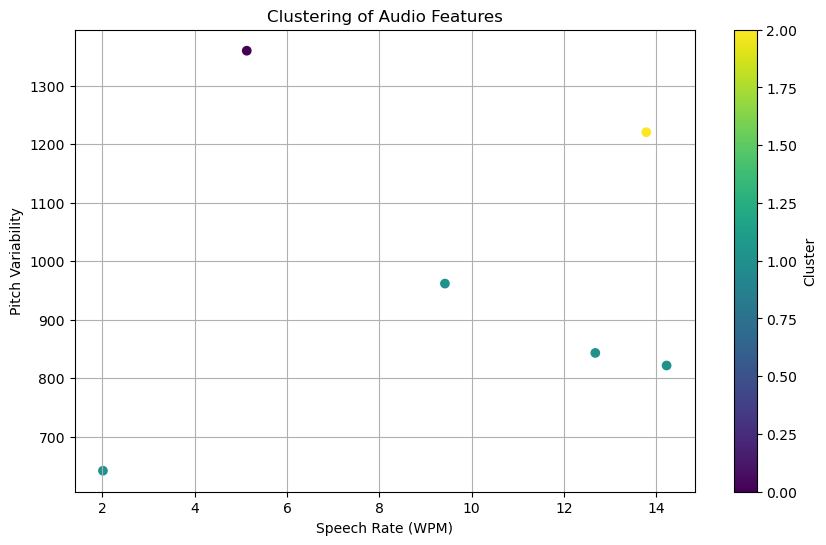

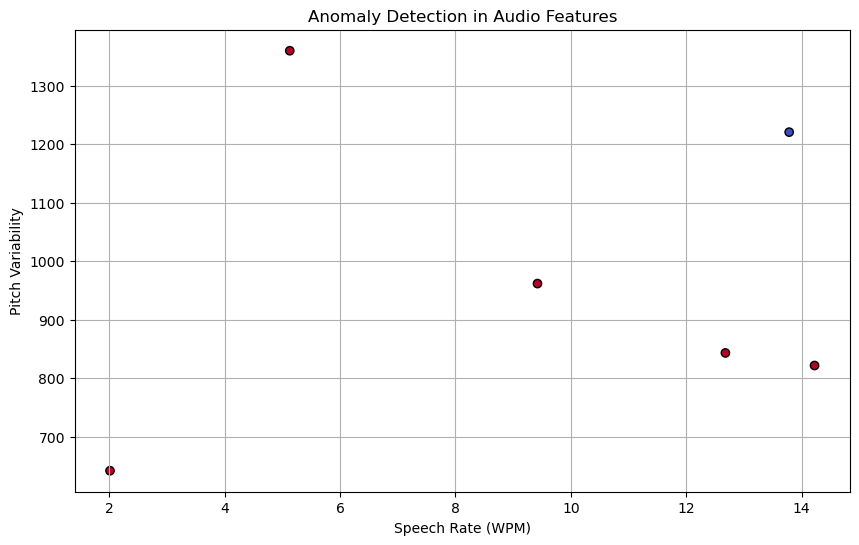

In [3]:
import os
import librosa
import numpy as np
import pandas as pd
import whisper
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# Load models
asr_model = whisper.load_model("base")
nlp = spacy.load("en_core_web_sm")

# Directory containing audio files
audio_dir = './samples'

# Placeholder transcriptions (Replace with actual transcriptions or use ASR)
transcriptions = {
    '120444__juskiddink__free-music.wav': "This is a sample transcription.",
    '140337__arnebuhmann__kidsontrain.wav': "Another sample transcription.",
    '497112__ajwphotographic__request-eduardr-we-read-and-write.wav': "Yet another sample.",
    '527426__michellelindemann1__what-do-you-think-is-going-to-happen-anyway.wav': "What do you think?",
    '527428__michellelindemann1__i-think-theres-a-message-outside-for-you.wav': "There's a message outside.",
    '527548__michellelindemann1__i-love-him.wav': "I love him."
}

# Feature extraction function
def extract_features(audio_file, transcription):
    y, sr = librosa.load(audio_file, sr=16000)
    duration = librosa.get_duration(y=y, sr=sr)
    words = len(transcription.split())
    speech_rate = words / (duration / 60)

    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_variability = np.std(pitches[pitches > 0])

    pauses = transcription.count('.') + transcription.count('!') + transcription.count('?')
    hesitation_markers = transcription.lower().count('uh') + transcription.lower().count('um')

    doc = nlp(transcription)
    vague_words = ['thing', 'stuff', 'it']
    vague_count = sum(1 for token in doc if token.text.lower() in vague_words)

    sentences = list(doc.sents)
    avg_sentence_length = np.mean([len(sent.text.split()) for sent in sentences]) if sentences else 0

    return {
        'speech_rate': speech_rate,
        'pitch_variability': pitch_variability,
        'pauses': pauses,
        'hesitation_markers': hesitation_markers,
        'vague_words': vague_count,
        'avg_sentence_length': avg_sentence_length,
    }

# Process audio files and extract features
features_list = []
for audio_file in os.listdir(audio_dir):
    if audio_file.endswith('.wav'):
        transcription = transcriptions.get(audio_file, "")
        features = extract_features(os.path.join(audio_dir, audio_file), transcription)
        features['file_name'] = audio_file
        features_list.append(features)

# Create DataFrame
features_df = pd.DataFrame(features_list)
print("\nExtracted Features:")
print(features_df)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df[['speech_rate', 'pitch_variability', 'pauses', 'hesitation_markers', 'vague_words', 'avg_sentence_length']])

# Clustering with KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
features_df['cluster'] = kmeans.fit_predict(scaled_features)

# Anomaly detection
isoforest = IsolationForest(contamination=0.2, random_state=42)
features_df['anomaly'] = isoforest.fit_predict(scaled_features)

# Display clustering and anomaly results
print("\nClustered & Anomaly-Labeled Data:")
print(features_df[['file_name', 'speech_rate', 'pitch_variability', 'pauses', 'hesitation_markers', 'vague_words', 'avg_sentence_length', 'cluster', 'anomaly']])

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(features_df['speech_rate'], features_df['pitch_variability'], c=features_df['cluster'], cmap='viridis')
plt.xlabel('Speech Rate (WPM)')
plt.ylabel('Pitch Variability')
plt.title('Clustering of Audio Features')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(features_df['speech_rate'], features_df['pitch_variability'], c=features_df['anomaly'], cmap='coolwarm', edgecolors='k')
plt.xlabel('Speech Rate (WPM)')
plt.ylabel('Pitch Variability')
plt.title('Anomaly Detection in Audio Features')
plt.grid(True)
plt.show()